In [102]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from datetime import timedelta
import matplotlib.pyplot as plt
import scipy.stats as st

# Reflect Tables into SQLAlchemy ORM

In [16]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [75]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")
conn = engine.connect()

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [85]:
# Find the most recent date in the data set.
first_row = session.query(Measurement).order_by(desc('date')).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fe9815ec940>,
 'station': 'USC00519397',
 'prcp': 0.0,
 'tobs': 81.0,
 'id': 2724,
 'date': '2017-08-23'}

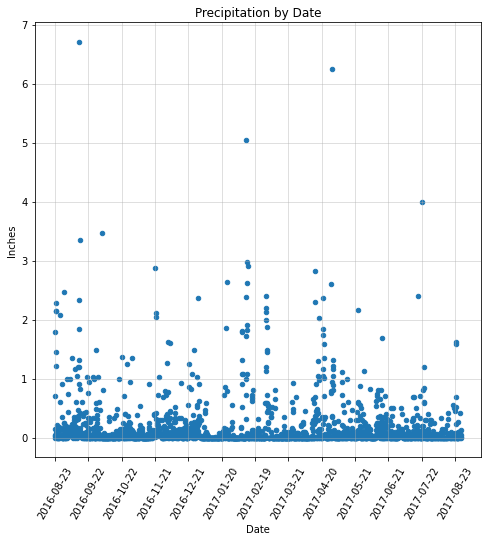

In [129]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.

# Perform a query to retrieve the data and precipitation scores
precip_12mo = session.query(Measurement).order_by('date').filter(Measurement.date >= (dt.strptime(first_row.date, '%Y-%m-%d') - timedelta(days=366)))
data_year = [{each_item.date:each_item.prcp} for each_item in precip_12mo]

# Save the query results as a Pandas DataFrame and set the index to the date column

df = pd.read_sql('SELECT * FROM Measurement WHERE "date" >= "{}"'.format(dt.strptime(first_row.date, '%Y-%m-%d') - timedelta(days=366)), conn)

# Sort the dataframe by date
df.sort_values(by=['date','id'])

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(kind='scatter', x='date', y='prcp', figsize=(8,8), title='Precipitation by Date')
plt.xticks(np.arange(0,367, 30), rotation=60)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.grid(alpha=.5)
plt.show()


In [213]:
# Use Pandas to calculate the summary statistics for the precipitation data


# Exploratory Station Analysis

In [138]:
# Design a query to calculate the total number stations in the dataset
session.query(Station).count()

9

In [147]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(desc(func.count(Measurement.station))).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [184]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(desc(func.count(Measurement.station))).first().station
lowest = session.query(Measurement).order_by(Measurement.tobs).filter(Measurement.station == most_active).first().tobs
highest = session.query(Measurement).order_by(desc(Measurement.tobs)).filter(Measurement.station == most_active).first().tobs
average = np.mean(session.query(Measurement.tobs).filter(Measurement.station == most_active).all())
print(f'''Station {most_active}:
Lowest Temperature: {lowest}
Highest Temperature: {highest}
Average Temperature: {average}''')

Station USC00519281:
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


In [189]:
# finding the lowest, highest, and average TOBS with single query
tobs_query = session.query(Measurement.station,\
    func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == most_active).all()
tobs_query

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

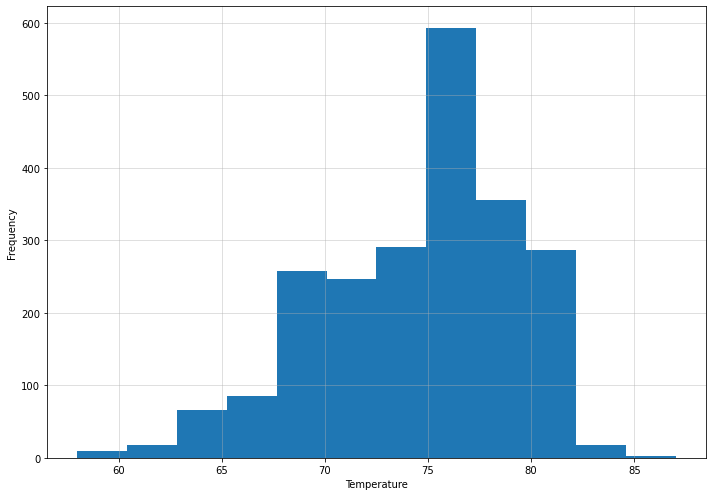

In [207]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_year = session.query(Measurement).order_by('date').filter(Measurement.date >= (dt.strptime(first_row.date, '%Y-%m-%d') - timedelta(days=366)))
st_year_tobs = [station.tobs for station in station_year]

x = st_year_tobs
fig, axs = plt.subplots(1, 1, figsize =(10, 7), tight_layout = True) 
axs.hist(x, bins=12)
plt.grid(alpha=.5)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

# Close session

In [214]:
# Close Session
session.close()